In [45]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

def pre_process(data):
    sentences = list()
    tags = list()
    sentence = list()
    tag = list()
    for line in data:
        if line == '\n':
            if sentence:
                sentences.append(sentence)
                tags.append(tag)
                sentence = list()
                tag = list()
        else:
            elements = line.split()
            if elements[0] == '-DOCSTART-':
                continue
            sentence.append(elements[0].upper())
            tag.append(elements[-1])
    if sentence:
        sentences.append(sentence)
        tags.append(tag)

    return list(zip(sentences, tags))


class Glove_embedding():
    def __init__(self, train_zip, test_zip, trained_dict=None):
        if trained_dict is None:
            trained_dict = dict()
        self.dict_words = dict()
        self.trained_dict = trained_dict
        train_zip.sort(key=lambda x: len(x[0]))
        test_zip.sort(key=lambda x: len(x[0]))
        self.train_x, self.train_y = zip(*train_zip)
        self.test_x, self.test_y = zip(*test_zip)
        self.train_x_matrix = list()
        self.test_x_matrix = list()
        self.train_y_matrix = list()
        self.test_y_matrix = list()
        self.len_words = 1
        self.len_tag = 3
        self.longest = 0
        self.embedding = list()
        self.tag_dict = {'<pad>': 0, '<begin>': 1, '<end>': 2}

    def get_words(self):
        self.embedding.append([0] * 50)
        for term in self.train_x:
            for word in term:  # Process every word
                if word not in self.dict_words:
                    self.dict_words[word] = len(self.dict_words)+1
                    if word in self.trained_dict:
                        self.embedding.append(self.trained_dict[word])
                    else:
                        # print(word)
                        # raise Exception("words not found!")
                        self.embedding.append([0] * 50)
        for term in self.test_x:
            for word in term:  # Process every word
                if word not in self.dict_words:
                    self.dict_words[word] = len(self.dict_words)+1
                    if word in self.trained_dict:
                        self.embedding.append(self.trained_dict[word])
                    else:
                        # print(word)
                        # raise Exception("words not found!")
                        self.embedding.append([0] * 50)
        for tags in self.train_y:
            for tag in tags:
                if tag not in self.tag_dict:
                    self.tag_dict[tag] = len(self.tag_dict)
        for tags in self.test_y:
            for tag in tags:
                if tag not in self.tag_dict:
                    self.tag_dict[tag] = len(self.tag_dict)
        self.len_tag = len(self.tag_dict)
        self.len_words = len(self.dict_words)+1

    def get_id(self):
        for term in self.train_x:
            item = [self.dict_words[word] for word in term]
            self.longest = max(self.longest, len(item))
            self.train_x_matrix.append(item)
        for term in self.test_x:
            item = [self.dict_words[word] for word in term]
            self.longest = max(self.longest, len(item))
            self.test_x_matrix.append(item)
        for tags in self.train_y:
            item = [self.tag_dict[tag] for tag in tags]
            self.train_y_matrix.append(item)
        for tags in self.test_y:
            item = [self.tag_dict[tag] for tag in tags]
            self.test_y_matrix.append(item)


class ClsDataset(Dataset):
    def __init__(self, sentence, tag):
        self.sentence = sentence
        self.tag = tag

    def __getitem__(self, item):
        return self.sentence[item], self.tag[item]

    def __len__(self):
        return len(self.tag)


def collate_fn(batch_data):
    sentence, tag = zip(*batch_data)
    sentences = [torch.LongTensor(sent) for sent in sentence]
    padded_sents = pad_sequence(sentences, batch_first=True, padding_value=0)
    tags = [torch.LongTensor(t) for t in tag]
    padded_tags = pad_sequence(tags, batch_first=True, padding_value=0)
    return torch.LongTensor(padded_sents), torch.LongTensor(padded_tags)


def get_batch(x, y, batch_size):
    dataset = ClsDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True, collate_fn=collate_fn)
    return dataloader


In [46]:
import torch.nn as nn
import torch

device = ('cuda' if torch.cuda.is_available() else 'cpu')

class Named_Entity_Recognition(nn.Module):
    
    def __init__(self, len_feature, len_words, len_hidden, type_num, pad_id, start_id, end_id, weight=None,
                 drop_out=0.5):
        super(Named_Entity_Recognition, self).__init__()
        self.len_feature = len_feature
        self.len_words = len_words
        self.len_hidden = len_hidden
        self.dropout = nn.Dropout(drop_out)
        if weight is None:
            x = nn.init.xavier_normal_(torch.Tensor(len_words, len_feature))
            self.embedding = nn.Embedding(num_embeddings=len_words, embedding_dim=len_feature, _weight=x).to(device)
        else:
            self.embedding = nn.Embedding(num_embeddings=len_words, embedding_dim=len_feature, _weight=weight).to(device)
        self.lstm = nn.LSTM(input_size=len_feature, hidden_size=len_hidden, batch_first=True, bidirectional=True).to(device)
        self.fc = nn.Linear(2 * len_hidden, type_num).to(device)
        self.crf = CRF(type_num, pad_id, start_id, end_id).to(device)

    def forward(self, x, tags, mask):
        mask = mask.int()
        x = self.embedding(x)
        x = self.dropout(x)
        self.lstm.flatten_parameters()
        x, _ = self.lstm(x)
        scores = self.fc(x)
        loss = self.crf(scores, tags, mask)
        return loss

    def predict(self, x, mask):
        mask = mask.int()
        x = self.embedding(x)
        x = self.dropout(x)
        self.lstm.flatten_parameters()
        x, _ = self.lstm(x)
        scores = self.fc(x)

        return self.crf.predict(scores, mask)


class CRF(nn.Module):

    def __init__(self, type_num, pad_id, start_id, end_id):
        super(CRF, self).__init__()
        self.type_num = type_num
        self.pad_id = pad_id
        self.start_id = start_id
        self.end_id = end_id

        transition = torch.zeros(type_num, type_num)
        transition[:, start_id] = -10000.0
        transition[end_id, :] = -10000.0
        transition[:, pad_id] = -10000.0
        transition[pad_id, :] = -10000.0
        transition[pad_id, pad_id] = 0.0
        transition[pad_id, :end_id] = 0.0

        self.transition = nn.Parameter(transition).to(device)

    def forward(self, scores, tags, mask):
        true_prob = self.true_prob(scores, tags, mask)
        total_prob = self.total_prob(scores, mask)
        return -torch.sum(true_prob - total_prob)

    def true_prob(self, scores, tags, mask):
        batch_size, sequence_len = tags.shape
        true_prob = torch.zeros(batch_size).to(device)

        first_tag = tags[:, 0]
        last_tag_index = mask.sum(1) - 1
        last_tag = torch.gather(tags, 1, last_tag_index.unsqueeze(1)).squeeze(1)

        tran_score = self.transition[self.start_id, first_tag]
        tag_score = torch.gather(scores[:, 0], 1, first_tag.unsqueeze(1)).squeeze(1)

        true_prob += tran_score + tag_score

        for i in range(1, sequence_len):
            non_pad = mask[:, i]
            pre_tag = tags[:, i - 1]
            curr_tag = tags[:, i]

            tran_score = self.transition[pre_tag, curr_tag]
            tag_score = torch.gather(scores[:, i], 1, curr_tag.unsqueeze(1)).squeeze(1)

            true_prob += tran_score * non_pad + tag_score * non_pad

        true_prob += self.transition[last_tag, self.end_id]

        return true_prob

    def total_prob(self, scores, mask):
        batch_size, sequence_len, num_tags = scores.shape
        log_sum_exp_prob = self.transition[self.start_id, :].unsqueeze(0) + scores[:, 0]
        for i in range(1, sequence_len):
            every_log_sum_exp_prob = list()
            for j in range(num_tags):
                tran_score = self.transition[:, j].unsqueeze(0)
                tag_score = scores[:, i, j].unsqueeze(1)

                prob = tran_score + tag_score + log_sum_exp_prob

                every_log_sum_exp_prob.append(torch.logsumexp(prob, dim=1))

            new_prob = torch.stack(every_log_sum_exp_prob).t()

            non_pad = mask[:, i].unsqueeze(-1)
            log_sum_exp_prob = non_pad * new_prob + (1 - non_pad) * log_sum_exp_prob

        tran_score = self.transition[:, self.end_id].unsqueeze(0)
        return torch.logsumexp(log_sum_exp_prob + tran_score, dim=1)

    def predict(self, scores, mask):
        batch_size, sequence_len, num_tags = scores.shape
        total_prob = self.transition[self.start_id, :].unsqueeze(0) + scores[:, 0]
        tags = torch.cat([torch.tensor(range(num_tags)).view(1, -1, 1) for _ in range(batch_size)], dim=0).to(device)
        for i in range(1, sequence_len):
            new_prob = torch.zeros(batch_size, num_tags).to(device)
            new_tag = torch.zeros(batch_size, num_tags, 1).to(device)
            for j in range(num_tags):
                prob = total_prob + self.transition[:, j].unsqueeze(0) + scores[:, i, j].unsqueeze(1)
                max_prob, max_tag = torch.max(prob, dim=1)
                new_prob[:, j] = max_prob
                new_tag[:, j, 0] = max_tag

            non_pad = mask[:, i].unsqueeze(-1)
            total_prob = non_pad * new_prob + (1 - non_pad) * total_prob
            non_pad=non_pad.unsqueeze(-1)
            temp_tag=torch.cat([torch.tensor(range(num_tags)).view(1, -1, 1) for _ in range(batch_size)], dim=0).to(device)
            append_tag = non_pad * temp_tag + (1 - non_pad) * torch.ones(batch_size, num_tags, 1).to(device) * self.pad_id

            new_tag=new_tag.long()
            pre_tag=tags[[ [i]*num_tags for i in range(batch_size)],new_tag[:,:,0],:]

            tags = torch.cat([pre_tag, append_tag], dim=-1)

        prob = total_prob + self.transition[:, self.end_id].unsqueeze(0)
        _, max_tag = torch.max(prob, dim=1)

        return tags[[ i for i in range(batch_size)], max_tag]

In [47]:
import matplotlib.pyplot
import torch
from torch import optim

def NN_embdding(model, train, test, learning_rate, iter_times,batch_size):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_record = list()
    test_loss_record = list()
    train_record = list()
    test_record = list()
    # torch.autograd.set_detect_anomaly(True)

    for iteration in range(iter_times):
        model.train()
        for i, batch in enumerate(train):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            mask = (y != 0).to(device)
            loss = model(x, y, mask).to(device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        train_acc = list()
        test_acc = list()
        train_loss = 0
        test_loss = 0
        for i, batch in enumerate(train):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            mask = (y != 0).to(device)
            loss = model(x, y, mask).to(device)
            train_loss += loss.item() / batch_size / y.shape[1]
            pred = model.predict(x, mask)
            acc = (pred == y).float()
            len_batch,len_seq=acc.shape
            points=torch.ones((1,len_batch)).to(device)
            for j in range(len_seq):
                points*=acc[:,j]
            train_acc.append(points.mean())

        for i, batch in enumerate(test):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            mask = (y != 0).to(device)
            loss = model(x, y, mask).to(device)
            test_loss += loss.item() / batch_size / y.shape[1]
            pred = model.predict(x, mask)
            acc = (pred == y).float()
            len_batch,len_seq=acc.shape
            points=torch.ones((1,len_batch)).to(device)
            for j in range(len_seq):
                points*=acc[:,j]
            test_acc.append(points.mean())

        trains_acc = sum(train_acc) / len(train_acc)
        tests_acc = sum(test_acc) / len(test_acc)

        train_loss_record.append(train_loss / len(train))
        test_loss_record.append(test_loss / len(test))
        train_record.append(trains_acc)
        test_record.append(tests_acc)
        print("---------- Iteration", iteration + 1, "----------")
        print("Train loss:", train_loss / len(train))
        print("Test loss:", test_loss / len(test))
        print("Train accuracy:", trains_acc)
        print("Test accuracy:", tests_acc)

    return train_loss_record, test_loss_record, train_record, test_record


def NN_plot(random_embedding, glove_embedding, len_feature, len_hidden, learning_rate, batch_size, iter_times):
    train_random = get_batch(random_embedding.train_x_matrix, random_embedding.train_y_matrix, batch_size)
    test_random = get_batch(random_embedding.test_x_matrix, random_embedding.test_y_matrix, batch_size)
    train_glove = get_batch(glove_embedding.train_x_matrix, glove_embedding.train_y_matrix, batch_size)
    test_glove = get_batch(glove_embedding.test_x_matrix, glove_embedding.test_y_matrix, batch_size)
    random_model = Named_Entity_Recognition(len_feature, random_embedding.len_words, len_hidden,
                                            random_embedding.len_tag, 0, 1, 2)
    glove_model = Named_Entity_Recognition(len_feature, random_embedding.len_words, len_hidden,
                                           random_embedding.len_tag, 0, 1, 2,
                                           weight=torch.tensor(glove_embedding.embedding, dtype=torch.float))
    trl_ran, tsl_ran, tra_ran, tea_ran = NN_embdding(random_model, train_random, test_random, learning_rate,
                                                     iter_times,batch_size)
    trl_glo, tsl_glo, tra_glo, tea_glo = NN_embdding(glove_model, train_glove, test_glove, learning_rate,
                                                     iter_times,batch_size)
    x = list(range(1, iter_times + 1))
    matplotlib.pyplot.subplot(2, 2, 1)
    matplotlib.pyplot.plot(x, trl_ran, 'r--', label='random')
    matplotlib.pyplot.plot(x, trl_glo, 'g--', label='glove')
    matplotlib.pyplot.legend(fontsize=10)
    matplotlib.pyplot.title("Train Loss")
    matplotlib.pyplot.xlabel("Iterations")
    matplotlib.pyplot.ylabel("Loss")
    matplotlib.pyplot.subplot(2, 2, 2)
    matplotlib.pyplot.plot(x, tsl_ran, 'r--', label='random')
    matplotlib.pyplot.plot(x, tsl_glo, 'g--', label='glove')
    matplotlib.pyplot.legend(fontsize=10)
    matplotlib.pyplot.title("Test Loss")
    matplotlib.pyplot.xlabel("Iterations")
    matplotlib.pyplot.ylabel("Loss")
    matplotlib.pyplot.subplot(2, 2, 3)
    matplotlib.pyplot.plot(x, tra_ran, 'r--', label='random')
    matplotlib.pyplot.plot(x, tra_glo, 'g--', label='glove')
    matplotlib.pyplot.legend(fontsize=10)
    matplotlib.pyplot.title("Train Accuracy")
    matplotlib.pyplot.xlabel("Iterations")
    matplotlib.pyplot.ylabel("Accuracy")
    matplotlib.pyplot.ylim(0, 1)
    matplotlib.pyplot.subplot(2, 2, 4)
    matplotlib.pyplot.plot(x, tea_ran, 'r--', label='random')
    matplotlib.pyplot.plot(x, tea_glo, 'g--', label='glove')
    matplotlib.pyplot.legend(fontsize=10)
    matplotlib.pyplot.title("Test Accuracy")
    matplotlib.pyplot.xlabel("Iterations")
    matplotlib.pyplot.ylabel("Accuracy")
    matplotlib.pyplot.ylim(0, 1)
    matplotlib.pyplot.tight_layout()
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(8, 8, forward=True)
    matplotlib.pyplot.savefig('main_plot.jpg')
    matplotlib.pyplot.show()


---------- Iteration 1 ----------
Train loss: 0.7254413833602202
Test loss: 0.7523309149715205
Train accuracy: tensor(0.2250)
Test accuracy: tensor(0.2224)
---------- Iteration 2 ----------
Train loss: 0.45925176729456185
Test loss: 0.5460758869688626
Train accuracy: tensor(0.3704)
Test accuracy: tensor(0.2853)
---------- Iteration 3 ----------
Train loss: 0.3434760800979242
Test loss: 0.47130923185322376
Train accuracy: tensor(0.4246)
Test accuracy: tensor(0.3247)
---------- Iteration 4 ----------
Train loss: 0.2740436473479306
Test loss: 0.42580604018988827
Train accuracy: tensor(0.5383)
Test accuracy: tensor(0.4368)
---------- Iteration 5 ----------
Train loss: 0.22321551963675876
Test loss: 0.3963778612453987
Train accuracy: tensor(0.6396)
Test accuracy: tensor(0.4700)
---------- Iteration 6 ----------
Train loss: 0.165920467188776
Test loss: 0.36430680192832715
Train accuracy: tensor(0.7539)
Test accuracy: tensor(0.4712)
---------- Iteration 7 ----------
Train loss: 0.115997111254

---------- Iteration 53 ----------
Train loss: 0.0018298123296916352
Test loss: 0.4152719872872651
Train accuracy: tensor(0.9965)
Test accuracy: tensor(0.5571)
---------- Iteration 54 ----------
Train loss: 0.0019059062442317095
Test loss: 0.4112051661590706
Train accuracy: tensor(0.9959)
Test accuracy: tensor(0.5600)
---------- Iteration 55 ----------
Train loss: 0.0017253461672290173
Test loss: 0.421288019756086
Train accuracy: tensor(0.9969)
Test accuracy: tensor(0.5597)
---------- Iteration 56 ----------
Train loss: 0.0019233549538241583
Test loss: 0.41339170001459413
Train accuracy: tensor(0.9970)
Test accuracy: tensor(0.5709)
---------- Iteration 57 ----------
Train loss: 0.0018326223907703914
Test loss: 0.4069268147001265
Train accuracy: tensor(0.9969)
Test accuracy: tensor(0.5768)
---------- Iteration 58 ----------
Train loss: 0.0015270483239343705
Test loss: 0.42554523350578505
Train accuracy: tensor(0.9973)
Test accuracy: tensor(0.5626)
---------- Iteration 59 ----------
Trai

---------- Iteration 5 ----------
Train loss: 0.14794418949328278
Test loss: 0.18307045791072976
Train accuracy: tensor(0.7219)
Test accuracy: tensor(0.6871)
---------- Iteration 6 ----------
Train loss: 0.1214283410360308
Test loss: 0.1644209963678098
Train accuracy: tensor(0.7526)
Test accuracy: tensor(0.7050)
---------- Iteration 7 ----------
Train loss: 0.10494337361233676
Test loss: 0.1555443816590093
Train accuracy: tensor(0.7737)
Test accuracy: tensor(0.7129)
---------- Iteration 8 ----------
Train loss: 0.0911440807874904
Test loss: 0.14820574447947066
Train accuracy: tensor(0.8005)
Test accuracy: tensor(0.7253)
---------- Iteration 9 ----------
Train loss: 0.08017347430209198
Test loss: 0.14312724102089147
Train accuracy: tensor(0.8200)
Test accuracy: tensor(0.7332)
---------- Iteration 10 ----------
Train loss: 0.07121927900043269
Test loss: 0.14068157008567364
Train accuracy: tensor(0.8381)
Test accuracy: tensor(0.7394)
---------- Iteration 11 ----------
Train loss: 0.063823

---------- Iteration 57 ----------
Train loss: 0.005477565676360884
Test loss: 0.15397048680906397
Train accuracy: tensor(0.9834)
Test accuracy: tensor(0.7712)
---------- Iteration 58 ----------
Train loss: 0.005150522709100378
Test loss: 0.1560502768473421
Train accuracy: tensor(0.9832)
Test accuracy: tensor(0.7679)
---------- Iteration 59 ----------
Train loss: 0.004909892972399885
Test loss: 0.15588199291978597
Train accuracy: tensor(0.9851)
Test accuracy: tensor(0.7656)
---------- Iteration 60 ----------
Train loss: 0.00483124284786199
Test loss: 0.1562330424091385
Train accuracy: tensor(0.9838)
Test accuracy: tensor(0.7679)
---------- Iteration 61 ----------
Train loss: 0.004673110007945099
Test loss: 0.15629193730426275
Train accuracy: tensor(0.9846)
Test accuracy: tensor(0.7706)
---------- Iteration 62 ----------
Train loss: 0.00449600881149354
Test loss: 0.15872472823989256
Train accuracy: tensor(0.9856)
Test accuracy: tensor(0.7697)
---------- Iteration 63 ----------
Train los

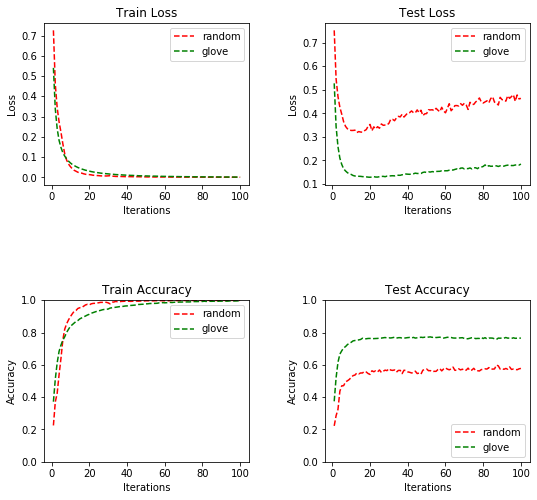

In [48]:
# %load main.py
from torch import optim
import random,numpy,torch

random.seed(2021)
numpy.random.seed(2021)
#torch.cuda.manual_seed(2021)
torch.manual_seed(2021)

with open('train.txt', 'r') as f:
    temp = f.readlines()

data = temp[2:]
train_zip = pre_process(data)

with open('test.txt', 'r') as f:
    temp = f.readlines()

data = temp[2:]
test_zip = pre_process(data)

with open('glove.6B.50d.txt', 'rb') as f:  # for glove embedding
    lines = f.readlines()

# Construct dictionary with glove

trained_dict = dict()
n = len(lines)
for i in range(n):
    line = lines[i].split()
    trained_dict[line[0].decode("utf-8").upper()] = [float(line[j]) for j in range(1, 51)]

random_embedding = Glove_embedding(train_zip, test_zip,trained_dict=None)
random_embedding.get_words()
random_embedding.get_id()

glove_embedding = Glove_embedding(train_zip, test_zip,trained_dict=trained_dict)
glove_embedding.get_words()
glove_embedding.get_id()


iter_times = 100
learning_rate=0.001
batch_size=100

NN_plot(random_embedding,glove_embedding,50,50,learning_rate,batch_size,iter_times)